# Data loading: TensorFlow TFRecord

## Overview

In this example we will show how to use the data stored in the TensorFlow TFRecord format with DALI.

## Creating index

In order to use data stored in the TFRecord format, we need to use `TFRecordReader` operator. Besides arguments common to all readers (like `random_shuffle`), it takes `path`, `index_path` and `features` arguments.

* `path` is a list of paths to TFRecord files
* `index_path` is a list containing paths to index files. Index files are used by DALI mainly to properly shard the dataset between multiple workers. The index for a given TFRecord file can be obtained from that file using `tfrecord2idx` utility included with DALI. Creating the index file is required only once per TFRecord file.
* `features` is a dictionary of pairs (name, feature), where feature (of type `dali.tfrecord.Feature`) describes the contents of the TFRecord. DALI features follow closely the TensorFlow types `tf.FixedLenFeature` and `tf.VarLenFeature`.

In [1]:
from subprocess import call
import os.path

tfrecord = "/data/imagenet/train-val-tfrecord-480/train-00001-of-01024"
tfrecord_idx = "idx_files/train-00001-of-01024.idx"
tfrecord2idx_script = "tfrecord2idx"

if not os.path.exists("idx_files"):
    os.mkdir("idx_files")

if not os.path.isfile(tfrecord_idx):
    call([tfrecord2idx_script, tfrecord, tfrecord_idx])

## Defining and running the pipeline

Let us define a simple pipeline that takes images stored in TFRecord format, decodes them and prepares them for ingestion in DL framework (crop, normalize and NHWC -> NCHW conversion).

TFRecord file that we used in this example was prepared using data preparation scripts from [Inception](https://github.com/tensorflow/models/tree/master/research/inception), which does not upscale images to common size. This results in an error during cropping, when the image is smaller than the crop window. To overcome that problem, we introduced `Resize` operation before cropping, which ensures that the shorter side of images being cropped is 256 pixels.

In [2]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import nvidia.dali.tfrecord as tfrec
import numpy as np
import matplotlib.pyplot as plt


class TFRecordPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(TFRecordPipeline, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = ops.TFRecordReader(path = tfrecord, 
                                        index_path = tfrecord_idx,
                                        features = {"image/encoded" : tfrec.FixedLenFeature((), tfrec.string, ""),
                                         'image/class/label':         tfrec.FixedLenFeature([1], tfrec.int64,  -1),
                                         'image/class/text':          tfrec.FixedLenFeature([ ], tfrec.string, ''),
                                         'image/object/bbox/xmin':    tfrec.VarLenFeature(tfrec.float32, 0.0),
                                         'image/object/bbox/ymin':    tfrec.VarLenFeature(tfrec.float32, 0.0),
                                         'image/object/bbox/xmax':    tfrec.VarLenFeature(tfrec.float32, 0.0),
                                         'image/object/bbox/ymax':    tfrec.VarLenFeature(tfrec.float32, 0.0)})
        self.decode = ops.nvJPEGDecoder(device = "mixed", output_type = types.RGB)
        self.resize = ops.Resize(device = "gpu", resize_shorter = 256.)
        self.cmnp = ops.CropMirrorNormalize(device = "gpu",
                                            output_dtype = types.FLOAT,
                                            crop = (224, 224),
                                            image_type = types.RGB,
                                            mean = [0., 0., 0.],
                                            std = [1., 1., 1.])
        self.uniform = ops.Uniform(range = (0.0, 1.0))
        self.iter = 0

    def define_graph(self):
        inputs = self.input()
        images = self.decode(inputs["image/encoded"])
        resized_images = self.resize(images)
        output = self.cmnp(resized_images, crop_pos_x = self.uniform(),
                           crop_pos_y = self.uniform())
        return (output, inputs["image/class/text"])

    def iter_setup(self):
        pass


Let us now build and run our `TFRecordPipeline`.

In [3]:
batch_size = 16

pipe = TFRecordPipeline(batch_size=batch_size, num_threads=4, device_id = 0)
pipe.build()

In [4]:
pipe_out = pipe.run()

In order to visualize the results we use `matplotlib` library. This library expects images in `HWC` format, whereas the output of our pipeline is in `CHW` (since that is the preferred format for most Deep Learning frameworks). Because of that, for the visualization purposes, we need to transpose the images back to `HWC` layout.

In [5]:
from __future__ import division
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(image_batch, labels):
    columns = 4
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        ascii = labels.at(j)
        plt.title("".join([chr(item) for item in ascii]))
        img_chw = image_batch.at(j)
        img_hwc = np.transpose(img_chw, (1,2,0))/255.0
        plt.imshow(img_hwc)

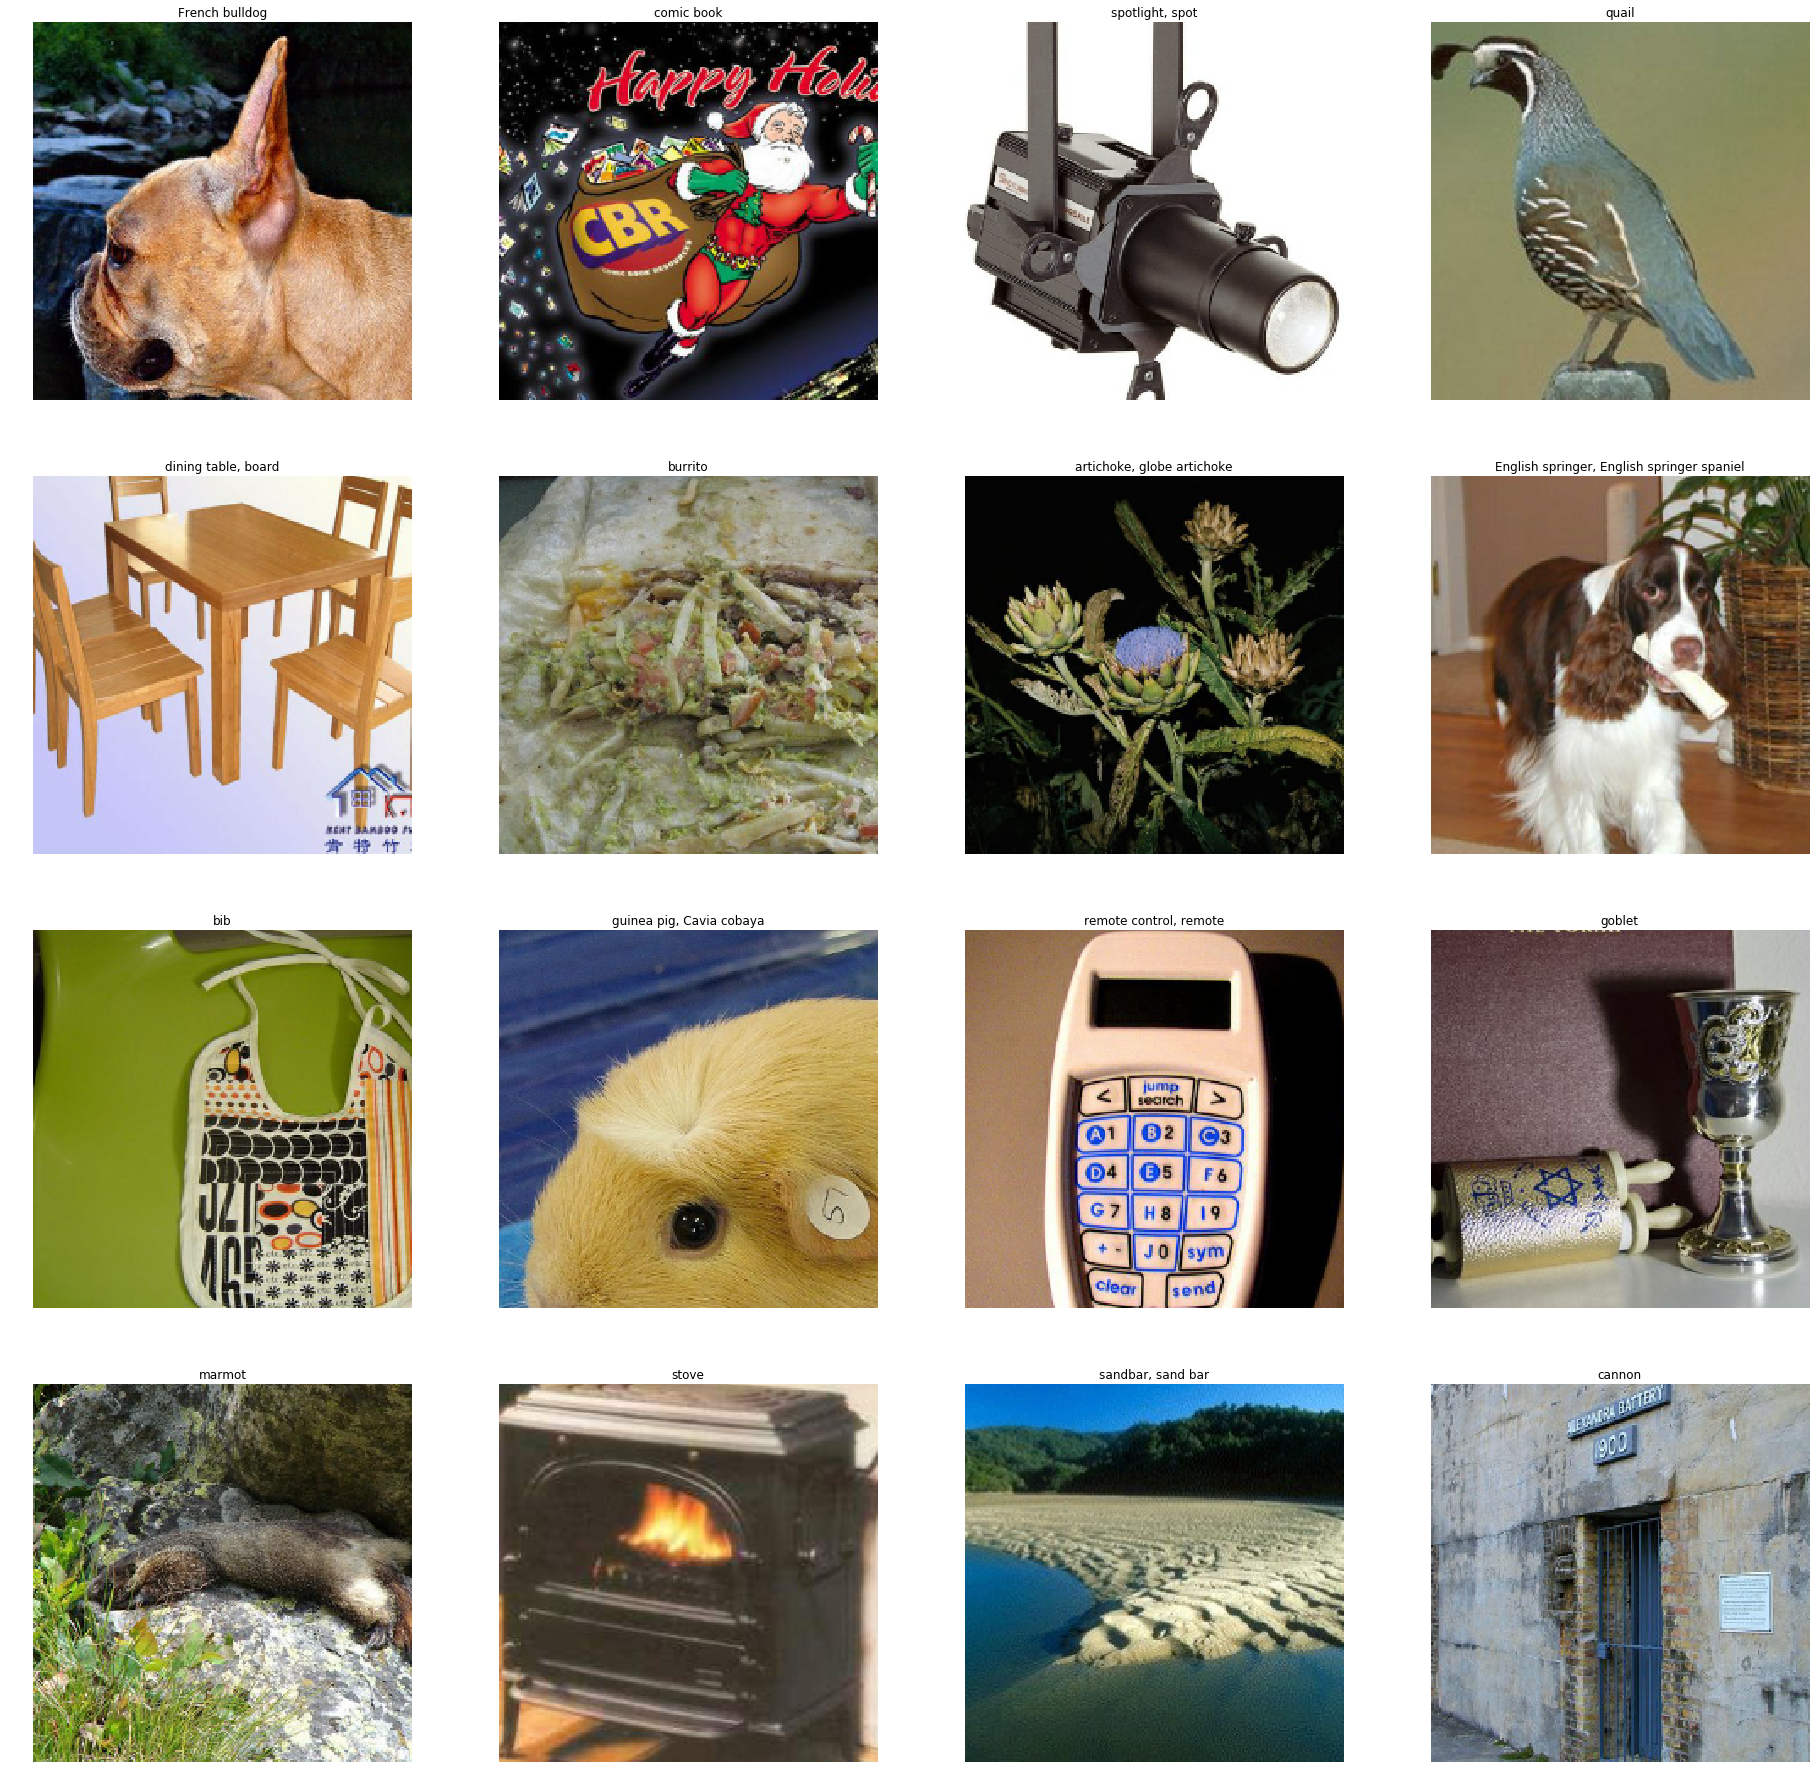

In [6]:
images, labels = pipe_out

show_images(images.asCPU(), labels)